In [1]:
!pip install datasets[vision] keras tensorflow opencv-python-headless matplotlib scikit-learn 

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for datasets[vision] from https://files.pythonhosted.org/packages/09/7e/fd4d6441a541dba61d0acb3c1fd5df53214c2e9033854e837a99dd9e0793/datasets-2.14.5-py3-none-any.whl.metadata
  Obtaining dependency information for keras from https://files.pythonhosted.org/packages/fe/58/34d4d8f1aa11120c2d36d7ad27d0526164b1a8ae45990a2fede31d0e59bf/keras-2.14.0-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e2/7a/c7762c698fb1ac41a7e3afee51dc72aa3ec74ae8d2f57ce19a9cded3a4af/tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/9d/d7/e2aaf344254292d2046f9984b54212e4e7d69a57d30ae15e7294840710f6/opencv_python_headless-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metad

In [2]:
# import modules
import datasets
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from functools import partial
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.manifold import TSNE
from PIL import Image

import tensorflow as tf
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import (load_img, img_to_array)
from tensorflow.keras.applications.vgg16 import (VGG16, preprocess_input)

2023-10-09 17:26:59.662898: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 17:26:59.703128: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 17:26:59.703155: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 17:26:59.703188: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-09 17:26:59.711190: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 17:26:59.711928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [5]:
features_train = np.load('features_train.npy')
features_test = np.load('features_test.npy')

Trying to get clustering to work with just the raw vgg16 features ('features_train')

In [5]:
dist = np.linalg.norm(features_test[0]-features_test[1])
print(dist)

99.242805


In [43]:
tsne_subset = features_train[0:1000]

In [10]:
images = datasets.load_from_disk("wiki_train")
images = images.select(list(range(1000)))['image']

In [45]:
X = np.array(tsne_subset)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 16.778705
[t-SNE] Computed conditional probabilities in 0.036s
[t-SNE] Iteration 50: error = 75.2227325, gradient norm = 0.1944472 (50 iterations in 0.324s)
[t-SNE] Iteration 100: error = 76.9519043, gradient norm = 0.1804837 (50 iterations in 0.138s)
[t-SNE] Iteration 150: error = 75.7502747, gradient norm = 0.4626056 (50 iterations in 0.144s)
[t-SNE] Iteration 200: error = 78.7038040, gradient norm = 0.2002726 (50 iterations in 0.151s)
[t-SNE] Iteration 250: error = 78.6502914, gradient norm = 0.2163862 (50 iterations in 0.150s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.650291
[t-SNE] Iteration 300: error = 1.7329535, gradient norm = 0.0156964 (50 iterations in 0.123s)
[t-SNE] Iteration 350: error = 1.6711313, gradient norm = 0.0024

In [46]:
#The variable tsne contains an array of unnormalized 2d points, corresponding to the embedding. In the next cell, we normalize the embedding so that lies entirely in the range (0,1).

tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

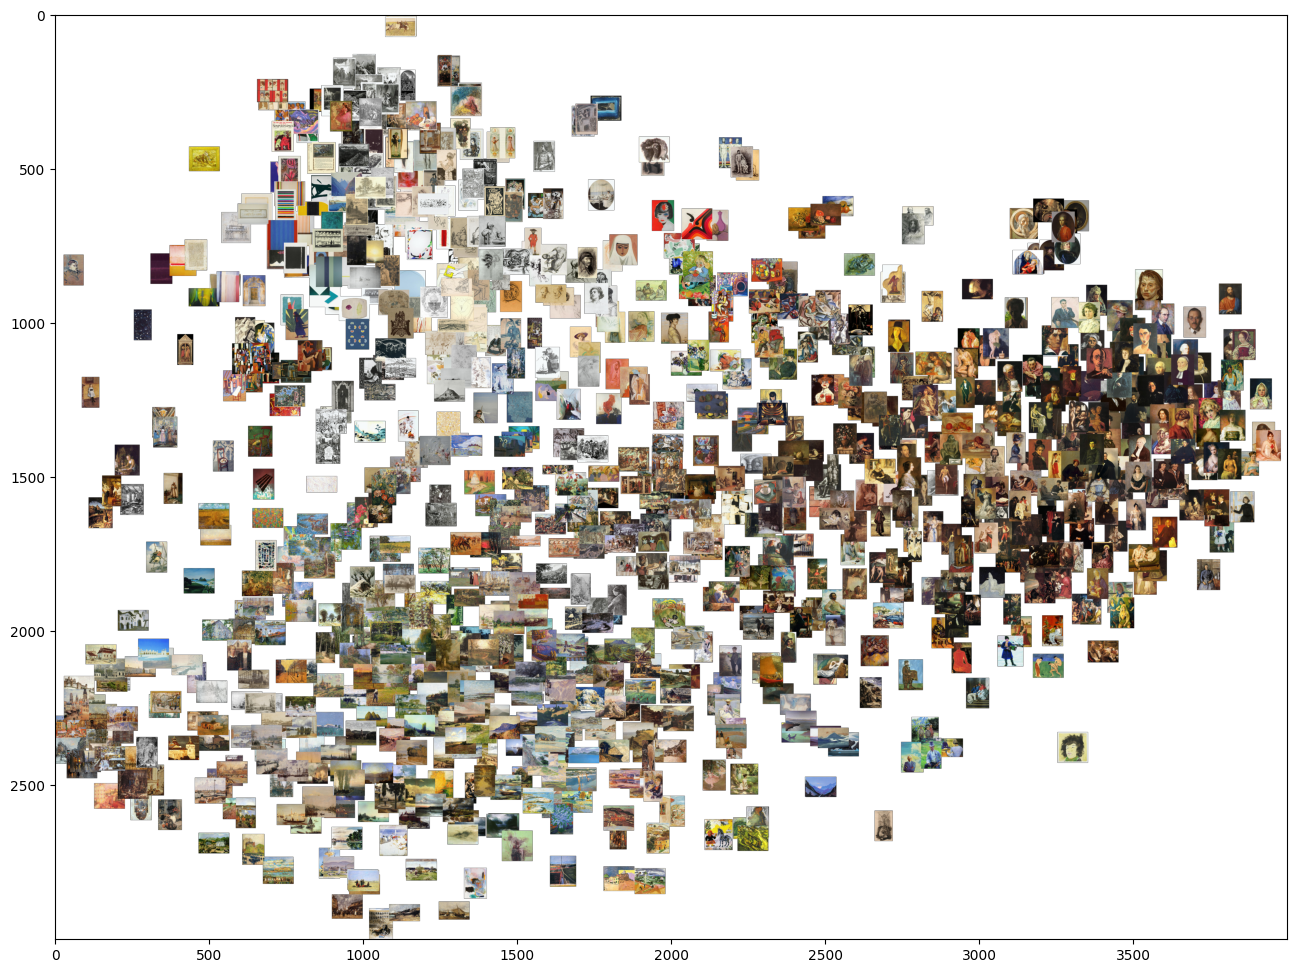

In [47]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = img
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.LANCZOS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

plt.figure(figsize = (16,12))
plt.imshow(full_image)

In [48]:
full_image.save("example-tSNE.png")

## t-SNE clustering with reconstructed images

In [4]:
autoencoder = tf.keras.models.load_model('autoencoder_small.keras')

In [6]:
reconstructions = autoencoder.predict(features_test)

313/313 [==============================] - 1s 2ms/step


In [11]:
reconstructed_subset = reconstructions[0:1000]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 16.354666
[t-SNE] Computed conditional probabilities in 0.043s
[t-SNE] Iteration 50: error = 71.1732254, gradient norm = 0.1534349 (50 iterations in 0.342s)
[t-SNE] Iteration 100: error = 70.8571930, gradient norm = 0.1632018 (50 iterations in 0.181s)
[t-SNE] Iteration 150: error = 71.6240692, gradient norm = 0.1719837 (50 iterations in 0.187s)
[t-SNE] Iteration 200: error = 73.1475220, gradient norm = 0.1144497 (50 iterations in 0.184s)
[t-SNE] Iteration 250: error = 73.1662598, gradient norm = 0.1450047 (50 iterations in 0.162s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.166260
[t-SNE] Iteration 300: error = 1.7062322, gradient norm = 0.0069126 (50 iterations in 0.143s)
[t-SNE] Iteration 350: error = 1.5948443, gradient norm = 0.0035

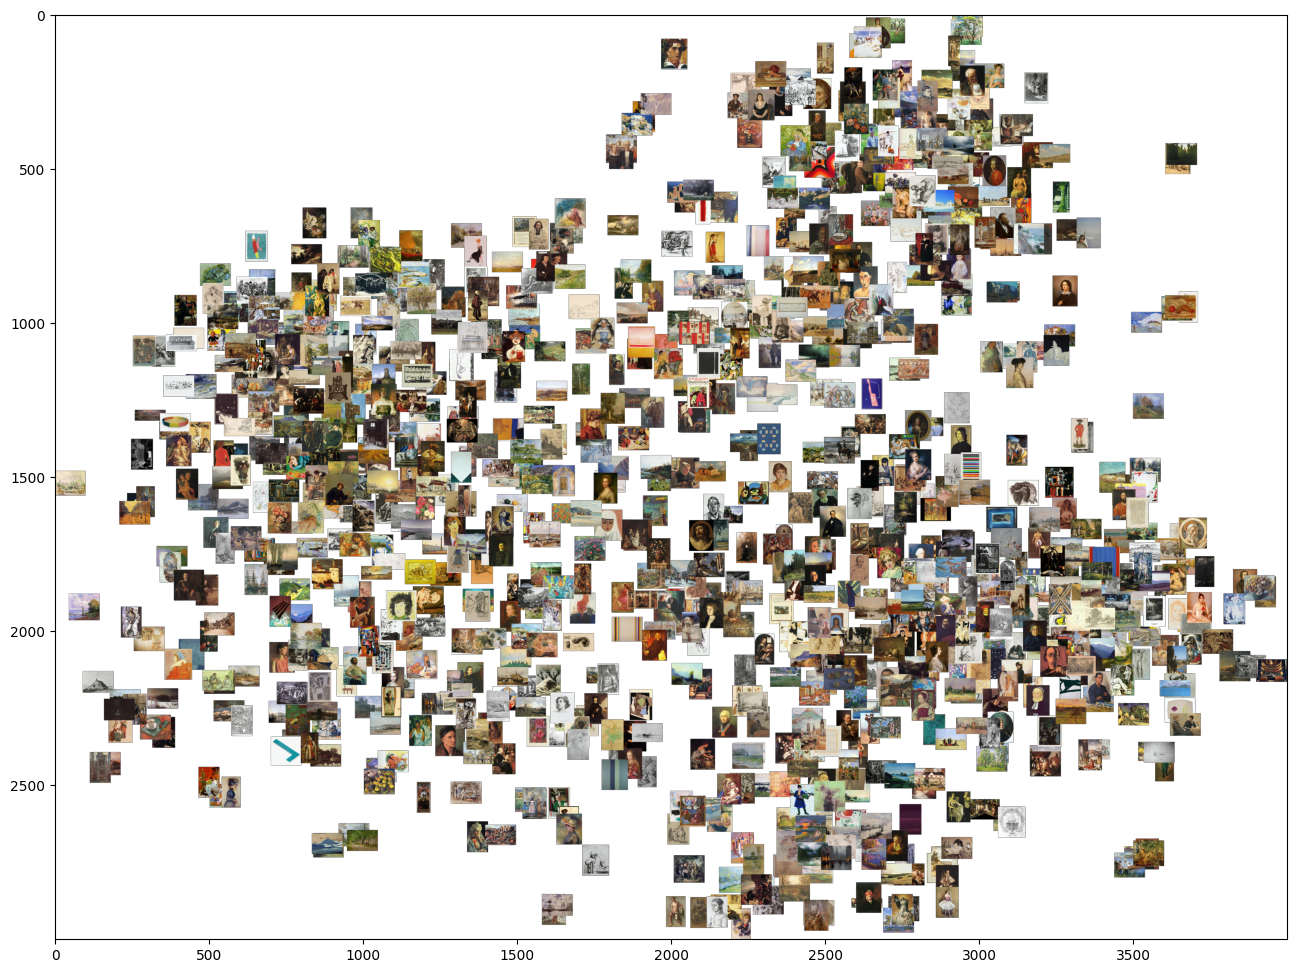

In [12]:
X = np.array(reconstructed_subset)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = img
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.LANCZOS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

plt.figure(figsize = (16,12))
plt.imshow(full_image)